## Region of interest extraction

Live-cell imaging files can be huge, in this notebook we will extract 4D subvolumes for downstream analysis.

In [1]:
%%capture
#suppresses output
import numpy as np #importing some packages we will need
import skimage.io
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/wsltools/programs/celltraj/celltraj')
import imageprep as imprep
import utilities
import skimage.filters
import scipy.ndimage
from skimage.filters import threshold_local
from skimage.segmentation import clear_border
import cmapfile
import pathlib
import nd2
from skimage.measure import regionprops_table
from IPython.display import clear_output

#### Step 1: Load and organize the image data

In [2]:
imagefile = '/mnt/e/Vaibhav/240213_ms_lung_w_t4_VM/2024.02.13_msLung_wT4_perfused_with_agarose001.nd2' #path to nd2 image file

In [3]:
imgs = nd2.imread(imagefile,dask=True)
imgs=np.swapaxes(imgs,3,5) #nd2 comes with an awkward channel order, rearranging
imgs=np.swapaxes(imgs,0,1)
nxy,nt,nz,nx,ny,nchannel=imgs.shape

In [4]:
print(nt)

25


##### Establish channels, imaging parameters, and object parameters-- use NIS AR or other software first to gather info

In [5]:
date = '2024.03.14'
modelName = f'20240213_T4lung_VM' #results will be saved/named using this string
ind_xy = np.arange(nxy).astype(int)#np.array([1]) #np.arange(nxy).astype(int)
#ind_xy = np.array([3,4]).astype(int) #choose xys for analysis. If all, use ind_xy = np.arange(nxy).astype(int)
nuc_channel=1 #nuclear channel
rep_channel=2 #reporter channel (ERK here)
bf_channel=3 #bright-field channel
channels = ['TRITC','Cy5','YFP','BF'] #names for channels in plots
channel_colors = ['red','magenta','goldenrod','gray'] #colors for channels in plots
channel_dict=dict([(x, i) for i, x in enumerate(channels)])
micron_per_pixel=.33 #lateral resolution (image pixel size)
micron_per_z=1.0 #axial resolution between z-slices
zscale=micron_per_z/micron_per_pixel
nucl=40 #typical nucleus linear diameter pixels

##### Check for effective image resolution using spherically averaged fourier transform

In [ ]:
nt_test=3;nz_test=3
test_times=np.linspace(0,nt-1,nt_test).astype(int)
test_z=np.linspace(0,nz-1,nz_test).astype(int)
nbin=int(nx/20.)
X, Y = np.ogrid[0:nx, 0:ny]
r = np.hypot(X - nx/2, Y - ny/2)
rbin = (nbin* r/r.max()).astype(int)

rng=np.random.default_rng(seed=1)
radial_means=np.zeros((ind_xy.size,nt_test,nchannel,nbin))
for ixy in range(ind_xy.size):
    for itt in range(nt_test):
        for ichannel in range(nchannel):
            for iz in range(nz_test):
                img=imgs[ind_xy[ixy],test_times[itt],test_z[iz],:,:,ichannel].compute()
                img_fft=np.log10(np.abs(np.fft.fftshift(np.fft.fftn(img))))
                radial_means[ixy,itt,ichannel,:] = scipy.ndimage.mean(img_fft, labels=rbin, index=np.arange(1, rbin.max() +1))
    print(f'fftr for xy{ixy}')

plt.figure()
plt.clf()
radial_means_xy=np.mean(radial_means,axis=1)
radial_means_channels=np.mean(radial_means,axis=(0,1))
lambda_bins=np.divide(nx*np.ones(nbin),np.linspace(1,r.max(),nbin))
for ixy in [0]:
    for ichannel in range(nchannel):
        plt.plot(1./lambda_bins,radial_means_xy[ixy,ichannel,:]-np.mean(radial_means_xy[ixy,ichannel,-5:-2]),'--',color=channel_colors[ichannel],alpha=.1) #,label=f't{itt} {channels[ichannel]}')
        if ixy==0:
            plt.plot(1./lambda_bins,radial_means_channels[ichannel,:]-np.mean(radial_means_channels[ichannel,-5:-2]),'-',color=channel_colors[ichannel],label=f'{channels[ichannel]}')
plt.ylabel('<log(fft(img))>')
plt.xlabel(r'spatial wavelength (pixels$^{-1}$)')
plt.legend(loc='upper right')
plt.savefig(f'fftr_{modelName}.png');plt.savefig(f'fftr_{modelName}.pdf')
plt.pause(.1)

fftr for xy0


In [6]:
#some convenience functions for later
def featSize(regionmask, intensity):
    size = np.sum(regionmask)
    return size

def meanIntensity(regionmask, intensity):
    mean_intensity = np.mean(intensity[regionmask])
    return mean_intensity

def totalIntensity(regionmask, intensity):
    sum_intensity = np.sum(intensity[regionmask])
    return sum_intensity

def show_3dseg_zproj(fig,im3d,labels,fmap=None,fmapscale=None,labels2=None):
    zproj=np.sum(im3d,axis=0)
    labels_zproj=np.max(labels,axis=0)
    plt.imshow(zproj,cmap=plt.cm.gray_r)
    plt.contour(labels_zproj,levels=np.arange(np.max(labels_zproj)),colors='blue',linewidths=1)
    if fmap is not None:
        #plt.contour(np.max(fmap,axis=0),levels=np.linspace(np.min(fmap),np.max(fmap),21),cmap=plt.cm.PiYG_r)
        plt.imshow(np.max(fmap,axis=0),cmap=plt.cm.YlOrRd,alpha=.33,clim=fmapscale)
    if labels2 is not None:
        labels2_zproj=np.max(labels2,axis=0)
        plt.contour(labels2_zproj,levels=np.arange(np.max(labels2_zproj)),colors='green',linewidths=1)
    plt.axis('equal');plt.axis('off')

#### Step 2: ROI extraction

We are going to extract cell-containing regions from the images using the bright-field channel. It is critical to examine the effectiveness of these foreground/background masks, and if necessary adjust parameters or try another method to get them accurate.

In [7]:
zcut = 2.0 #cut-off parameter for setting foreground mask from brightfield
scut = 5.0 #cut-off for enough nuclear/reporter signal
rsmooth = 4*nucl #smoothing size for foreground mask
sizecut = nucl*nucl*nucl/zscale #minimum size of region to keep as ROI
borders = [2,4*nucl,4*nucl] #extension beyond foreground masks to keep in saved ROI
save_bf_labels = False #whether to save foreground masks as their own file
nt_test=5; #number of times to check foreground mask to obtain overall bounding box
test_times=np.linspace(0,nt-1,nt_test).astype(int)
visual = True #show visualizations along the way
if test_times[-1]<nt-1:
    test_times=np.append(test_times,np.array([nt-1]).astype(int))

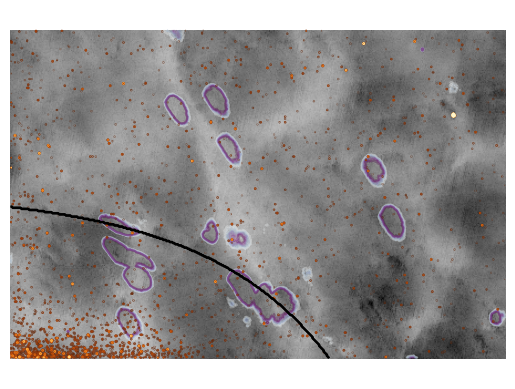

In [8]:
if visual:
    plt.close('all')
    fig=plt.figure(figsize=(10,10))
    
for ixy in ind_xy:
    labels_roi=np.zeros((nt_test,nz,nx,ny)).astype(np.uint8)
    figid=f'{modelName}_XY{ixy}'
    for itt in range(nt_test):
        iS=test_times[itt]
        sys.stdout.write(f'loading frame {iS} XY{ixy}... ')
        img=imgs[ixy,iS,...].compute()
        sys.stdout.write(' loaded\n')
        img_nuc=imprep.histogram_stretch(img[:,:,:,nuc_channel])
        img_nuc[img_nuc>50*np.std(img_nuc)]=0.
        img_bf=img[:,:,:,bf_channel]
        img_bf_dog=skimage.filters.difference_of_gaussians(imprep.znorm(img_bf),.5,1.5)
        img_fl=img[:,:,:,rep_channel]
        #img_bf_smth=skimage.filters.gaussian(np.abs(img_bf_dog),sigma=[rsmooth/zscale,rsmooth,rsmooth])
        img_fl_smth=skimage.filters.gaussian(img_fl,sigma=[rsmooth/zscale,rsmooth,rsmooth])
        #msk_bf=imprep.znorm(img_bf_smth)>zcut
        msk_fl=imprep.znorm(img_fl_smth)>zcut
        #msk_roi=np.logical_and(msk_bf,msk_fl)
        label=imprep.get_labeled_mask(msk_fl)
        props = regionprops_table(label, intensity_image=img_nuc,properties=('label','intensity_max'), extra_properties=(featSize,meanIntensity,totalIntensity))
        ind_empty = props['label'][props['intensity_max']<(np.mean(img_nuc)+scut*np.std(img_nuc))]
        ind_small = props['label'][props['featSize']<sizecut]
        for iempty in ind_empty:
            label[label==iempty]=0
        ind_small = props['label'][props['featSize']<sizecut]
        for iempty in np.setdiff1d(ind_small,ind_empty):
            label[label==iempty]=0
        fmsk=label>0
        label2=imprep.get_labeled_mask(fmsk)
        props2 = regionprops_table(label2, intensity_image=img_fl,properties=('label','intensity_max'), extra_properties=(featSize,meanIntensity,totalIntensity))
        ind_empty2 = props2['label'][props2['intensity_max']<(np.mean(img_fl)+scut*np.std(img_fl))]
        for iempty in ind_empty2:
            label2[label2==iempty]=0
        fmsk=label2>0
        label3=imprep.get_labeled_mask(fmsk)
        labels_roi[itt,...]=label3
        if visual and np.sum(label3>0):
            props3 = regionprops_table(label3, intensity_image=img_fl,properties=('label','centroid'), extra_properties=(featSize,meanIntensity,totalIntensity))
            clear_output(wait=True);plt.clf();
            show_3dseg_zproj(fig,np.abs(imprep.znorm(img_fl)),label3,fmap=imprep.get_feature_map(props3['meanIntensity'],label3))
            for iblob in range(props3['label'].size):
                plt.text(props3['centroid-2'][iblob],props3['centroid-1'][iblob],f"{props3['featSize'][iblob]:.2e} vox")
            plt.title(f'frame {iS}')
            plt.pause(.1);
            #plt.savefig(f'{date}/zproj_bflabels_{figid}_f{iS:04d}.png')
    labels_3d=np.max(labels_roi>0,axis=0)
    labels_3d=labels_3d.astype(int)
    num_labels=scipy.ndimage.label(labels_3d,output=labels_3d)
    if save_bf_labels:
        skimage.io.imsave(f'labels_{figid}.tif',labels_3d)
    labels_roi=np.max(labels_3d,axis=0).astype(int)
    if visual:
        clear_output(wait=True);plt.clf()
        plt.contour(labels_roi.T,levels=np.unique(labels_roi),cmap=plt.cm.viridis)
        xt=imprep.get_cell_centers(labels_3d)
        print(xt)
        for icenter in range(xt.shape[0]):
            if not np.isnan(np.sum(xt,axis=1)[icenter]):
                indcenter=xt[icenter,:].astype(int)
                ilabel=labels_3d[indcenter[0],indcenter[1],indcenter[2]]
                plt.text(xt[icenter,1],xt[icenter,2],str(ilabel),color='red')
        plt.pause(.1)
    props_rois = regionprops_table(labels_3d,properties=('label','area','bbox'))
    #extract roi and save as tif
    ind_rois=np.where(props_rois['area']>(nucl**3)/zscale)[0]
    n_rois=ind_rois.size
    tsi=np.array([0,0,0]).astype(int)
    for i_roi in range(n_rois):
        zlow=np.max([0,props_rois['bbox-0'][ind_rois[i_roi]]-borders[0]]);zhigh=np.min([nz,props_rois['bbox-3'][ind_rois[i_roi]]+borders[0]])
        xlow=np.max([0,props_rois['bbox-1'][ind_rois[i_roi]]-borders[1]]);xhigh=np.min([nx,props_rois['bbox-4'][ind_rois[i_roi]]+borders[1]])
        ylow=np.max([0,props_rois['bbox-2'][ind_rois[i_roi]]-borders[2]]);yhigh=np.min([ny,props_rois['bbox-5'][ind_rois[i_roi]]+borders[2]])
        img_roi=imgs[ixy,:,zlow:zhigh,xlow:xhigh,ylow:yhigh,:].compute()
        fname=f'{figid}_roi{i_roi}.tif'
        skimage.io.imsave(fname,img_roi)
        if visual:
            try:
                clear_output(wait=True);plt.clf();plt.imshow(imprep.znorm(np.max(img_roi[...,bf_channel],axis=(0,1))),cmap=plt.cm.binary,clim=(-5,5));
                cs=plt.contour(imprep.znorm(np.max(img_roi[...,nuc_channel],axis=(0,1))),cmap=plt.cm.BuPu,levels=np.linspace(1,np.percentile(imprep.znorm(img_roi[...,nuc_channel]),99),7),alpha=.3)
                cs.cmap.set_over('purple')
                cs=plt.contour(imprep.znorm(np.max(img_roi[...,rep_channel],axis=(0,1))),cmap=plt.cm.YlOrBr_r,levels=np.linspace(1,np.percentile(imprep.znorm(img_roi[...,rep_channel]),99),7),alpha=.7)
                cs.cmap.set_over('yellow')
                plt.contour(np.max(labels_3d[zlow:zhigh,xlow:xhigh,ylow:yhigh],axis=0),levels=[0,1],colors='black')
                plt.axis('equal');plt.axis('off');plt.savefig(f'{figid}_roi{i_roi}_maxp.png');plt.pause(.1)
            except Exception as e:
                print(e)


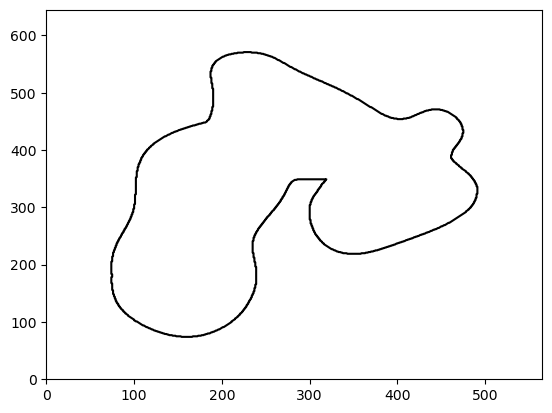

In [15]:
plt.contour(np.max(labels_3d[zlow:zhigh,xlow:xhigh,ylow:yhigh],axis=0),levels=[0,1],colors='black')

In [22]:
np.unique(label3)


array([0], dtype=int32)

In [12]:
np.min(img_roi)

333

In [13]:
np.max(img_roi)

6047

In [14]:
2**16

65536

In [15]:
2**8

256